# Fast Gradient Sign Method (FGSM) using Cleverhans

#### Easily implement an FGSM attack on a model using Cleverhans and Tensorflow 2.0
>
Checkout Cleverhans on Github [here](https://www.github.com/tensorflow/cleverhans).


## Import dependent libraries
Tensorflow 2.0 required 


In [ ]:
!pip install -q tensorflow==2.0.0b1
# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

/Users/pa-legg/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/pa-legg/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/pa-legg/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/pa-legg/opt/anaconda3/lib/python3.7/site-packages/tensorf

## Training a simple model on the MNIST dataset


> If you would like to experiment with other datasets feel free to replace this code by whatever you need to do so. Just remember that to make the rest of the notebook work without any other major changes keep the variables train_images, train_labels, test_images, test_labels and assign them to the corresponding new data. I recommend any of the datasets offered by keras as they use the same mechanics to import them.

>Keep in mind that the MNIST dataset was used in this guide because of the little amount of time it takes to both train a good model and craft the attacks.

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

num_classes = 10

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation(tf.nn.softmax) # We seperate the activation layer to be able to access the logits of the previous layer later
])

model.compile(optimizer='adam',
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10, validation_split=0.2)
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

11493376/11490434 [==============================] - 0s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 4s 75us/sample - loss: 0.4152 - accuracy: 0.8798 - val_loss: 0.2260 - val_accuracy: 0.9371
Epoch 2/10
48000/48000 [==============================] - 3s 70us/sample - loss: 0.1900 - accuracy: 0.9444 - val_loss: 0.1712 - val_accuracy: 0.9494
Epoch 3/10
48000/48000 [==============================] - 3s 69us/sample - loss: 0.1493 - accuracy: 0.9565 - val_loss: 0.1516 - val_accuracy: 0.9566
Epoch 4/10
48000/48000 [==============================] - 3s 71us/sample - loss: 0.1259 - accuracy: 0.9622 - val_loss: 0.1325 - val_accuracy: 0.9589
Epoch 5/10
48000/48000 [==============================] - 3s 70us/sample - loss: 0.1110 - accuracy: 0.9665 - val_loss: 0.1357 - val_accuracy: 0.9599
Epoch 6/10
48000/48000 [======================

## Implementing the FGSM attack using fast_gradient_method()


Cleverhans implements the fgsm attack with the following method:


```
fast_gradient_method(model_fn, x, eps, norm, clip_min=None, clip_max=None, y=None, targeted=False, sanity_checks=False)

```

> * **model_fn**: a callable that takes an input tensor and returns the model logits
* **x**: input_tensor
* **eps**: epsilon (dictates the "strength" of the distortion created)
* **norm**: Order of the norm (mimics NumPy). Possible values: np.inf, 1 or 2.
* **clip_min**: (optional, default=None) float. Minimum float value for adversarial example components.
* **clip_max**: (optional, default=None) float. Maximum float value for adversarial example components
* **y**: (optional, default=None) Tensor with true labels. If targeted is true, then provide the target label. Otherwise, only provide this parameter if you'd like to use true labels when crafting adversarial samples. Otherwise, model predictions are used as labels to avoid the "label leaking" effect (explained in this [paper](https://arxiv.org/abs/1611.01236)).
* **targeted**: (optional, default=False) bool. Is the attack targeted or untargeted? Untargeted, the default, will try to make the label incorrect. Targeted will instead try to move in the direction of being more like y.
* **param sanity_checks**: (optional, default=False) bool, if True, include  asserts (Turn them off to use less runtime / memory or for unit tests that intentionally pass strange input)
>

Find it in the library [here](https://github.com/tensorflow/cleverhans/blob/master/cleverhans/future/tf2/attacks/fast_gradient_method.py)

In [ ]:
# Import the attack
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

### Choose a random image to attack from the test set



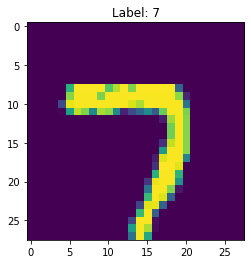

In [ ]:
random_index = np.random.randint(test_images.shape[0])

original_image = test_images[random_index]
original_image = tf.convert_to_tensor(original_image.reshape((1,28,28))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

original_label = test_labels[random_index]
original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(original_image, (28,28)))
plt.title("Label: {}".format(original_label[0]))

plt.show()

### Non-targeted FGSM attack


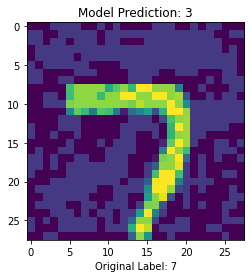

In [ ]:
epsilon = 0.1

adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)

adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_untargeted_label, (28,28)))
plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))

plt.show()

### Targeted FGSM Attack

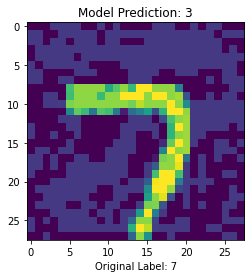

In [ ]:
epsilon = 0.1
# The target value may have to be changed to work, some images are more easily missclassified as different labels
target = 4

target_label = np.reshape(target, (1,)).astype('int64') # Give target label proper size and dtype to feed through

adv_example_targeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, y=target_label, targeted=True)

adv_example_targeted_label_pred = model.predict(adv_example_targeted_label)

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_targeted_label, (28,28)))
plt.title("Model Prediction: {}".format(np.argmax(adv_example_targeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))

plt.show()

### Other Docs
>
Find more tutorials for Cleverhans [here](https://github.com/tensorflow/cleverhans/tree/master/tutorials/future/tf2).